<a href="https://colab.research.google.com/github/saba18556/Data-Analysis/blob/New/IDM_Testing_(1)_(2)_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performing Regression on data from Zameen.com for predicting house prices

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [ ]:
!pip install dython
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import dython
import statsmodels.api as sm
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from dython import nominal


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
print(os.listdir())

['.config', 'drive', 'sample_data']


## Loading The Data

In [ ]:
DATADIR = "/content/drive/My Drive/Colab Notebooks/zameen.com_2019.csv"
df = pd.read_csv(DATADIR)
df = df.set_index("Unnamed: 0")
df.columns = df.columns.to_series().apply(lambda x: x.strip())
df

,property_type,price,location,city,province_name,latitude,longitude,baths,area,purpose,bedrooms,agence,agent,area.1,area unit,month,day,year
Unnamed: 0,,,,,,,,,,,,,,,,,,
0,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,8 Marla,For Sale,3,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,8.0,Marla,7,10,2019
1,Flat,7800000,E-11,Islamabad,Islamabad Capital,33.698244,72.984238,2,6.2 Marla,For Sale,2,Ettemad Enterprises,Balqiaz Marwat,6.2,Marla,5,5,2019
2,House,50000000,DHA Defence,Islamabad,Islamabad Capital,33.540894,73.095732,7,1 Kanal,For Sale,7,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,1.0,Kanal,10,19,2018
3,Penthouse,40000000,F-11,Islamabad,Islamabad Capital,33.679211,72.988787,5,1 Kanal,For Sale,5,Crown Associate,Abrar Ahmed,1.0,Kanal,6,27,2019
4,Flat,35000000,Diplomatic Enclave,Islamabad,Islamabad Capital,33.728873,73.119628,3,7.1 Marla,For Sale,3,Al Sahar Estate,Zahid H. Usmani,7.1,Marla,6,3,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72151,Flat,25000000,Jamshed Town,Karachi,Sindh,24.861596,67.054710,4,8.4 Marla,For Sale,4,Karsaz Estate,Muhammad Shahrukh,8.4,Marla,6,30,2019
72152,House,30000,Bahria Town Karachi,Karachi,Sindh,25.058062,67.306626,0,8 Marla,For Rent,3,ZPN Real Estate & Builders,Ali Raza,8.0,Marla,6,27,2019
72153,Lower Portion,10000,Malir,Karachi,Sindh,24.902505,67.201823,2,2.4 Marla,For Rent,2,Aarfi Estate Agency,Anwar Shah,2.4,Marla,7,3,2019


##Data Preparation

### Checking for Missing Values

In [ ]:
df.isnull().sum()

property_type    0
price            0
location         0
city             0
province_name    0
latitude         0
longitude        0
baths            0
area             0
purpose          0
bedrooms         0
agence           0
agent            0
area.1           0
area unit        0
month            0
day              0
year             0
dtype: int64

Since there are no missing values, there is no use of cleaning/replacing the data values

###Updating and Removing Irrelevant Column(s)
---
Updating column "area" to only marla to make data column continuous. Removing "area.1" and "area unit" because the 'area' column already contains relevant informtion.



In [ ]:
df['area'] = np.where(df['area unit'] == 'Kanal', df['area.1']*20, df['area.1'] )
df = df.drop(['area.1', 'area unit'],axis=1)
df

,property_type,price,location,city,province_name,latitude,longitude,baths,area,purpose,bedrooms,agence,agent,month,day,year
Unnamed: 0,,,,,,,,,,,,,,,,
0,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,8.0,For Sale,3,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,7,10,2019
1,Flat,7800000,E-11,Islamabad,Islamabad Capital,33.698244,72.984238,2,6.2,For Sale,2,Ettemad Enterprises,Balqiaz Marwat,5,5,2019
2,House,50000000,DHA Defence,Islamabad,Islamabad Capital,33.540894,73.095732,7,20.0,For Sale,7,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,10,19,2018
3,Penthouse,40000000,F-11,Islamabad,Islamabad Capital,33.679211,72.988787,5,20.0,For Sale,5,Crown Associate,Abrar Ahmed,6,27,2019
4,Flat,35000000,Diplomatic Enclave,Islamabad,Islamabad Capital,33.728873,73.119628,3,7.1,For Sale,3,Al Sahar Estate,Zahid H. Usmani,6,3,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72151,Flat,25000000,Jamshed Town,Karachi,Sindh,24.861596,67.054710,4,8.4,For Sale,4,Karsaz Estate,Muhammad Shahrukh,6,30,2019
72152,House,30000,Bahria Town Karachi,Karachi,Sindh,25.058062,67.306626,0,8.0,For Rent,3,ZPN Real Estate & Builders,Ali Raza,6,27,2019
72153,Lower Portion,10000,Malir,Karachi,Sindh,24.902505,67.201823,2,2.4,For Rent,2,Aarfi Estate Agency,Anwar Shah,7,3,2019


### Checking Correlation
A step of the filtering is done using correlation matrix.

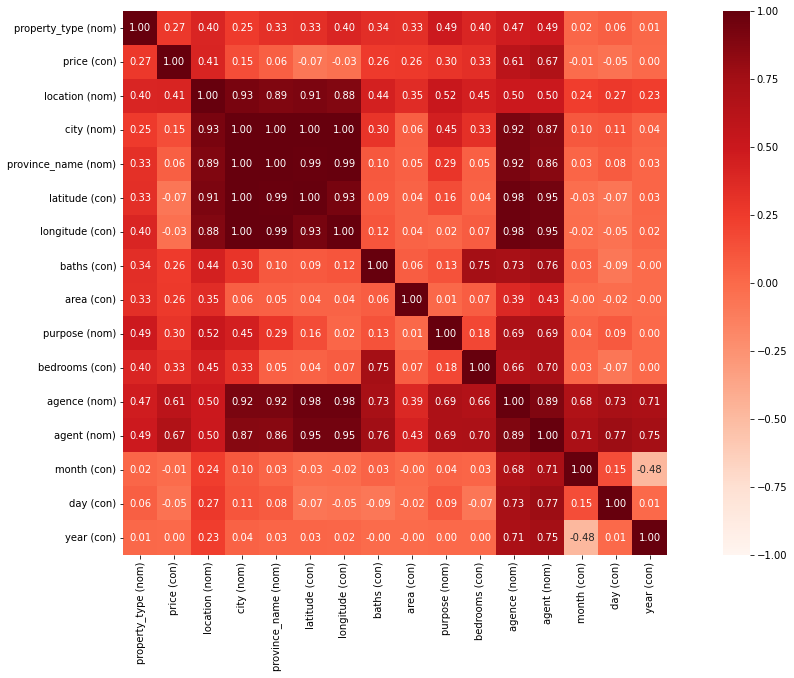

In [ ]:
cor = nominal.associations(df,figsize=(20,10),mark_columns=True, cmap=plt.cm.Reds);

In [ ]:
#Correlation with output variable
pricee = cor['corr']['price (con)']
cor_target = abs(pricee)

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.26]
relevant_features

property_type (nom)    0.273399
price (con)            1.000000
location (nom)         0.409236
area (con)             0.260420
purpose (nom)          0.301229
bedrooms (con)         0.328646
agence (nom)           0.609273
agent (nom)            0.673567
Name: price (con), dtype: float64

In [ ]:
#plt.figure(figsize=(12,10))
#cor = df.corr()
#sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
#plt.figure(figsize=(3, 3))
#plt.show()

In [ ]:
#Correlation with output variable
#cor_target = abs(cor["price (con)"])
#Selecting highly correlated features
#relevant_features = cor_target[cor_target>0.01]
#relevant_features

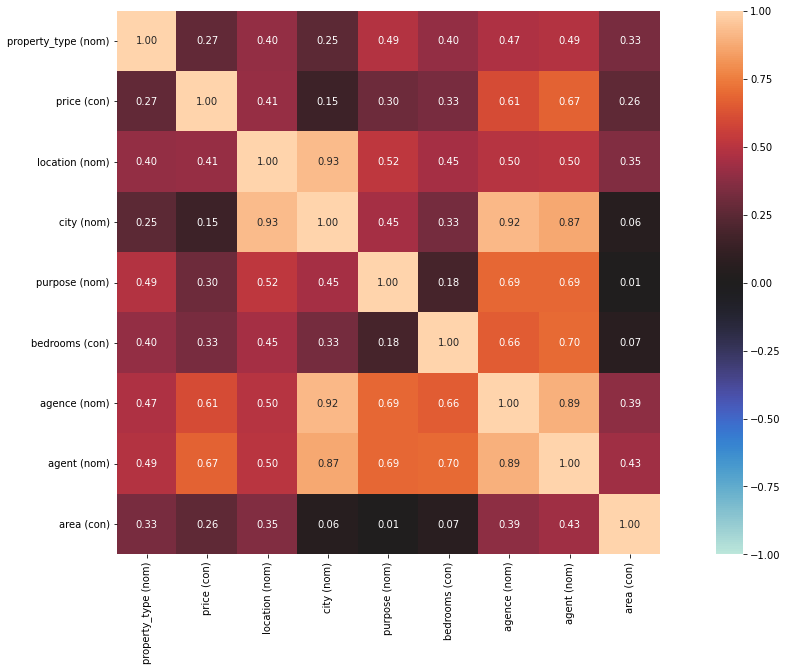

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fce53987b90>,
 'corr':                      property_type (nom)  price (con)  ...  agent (nom)  area (con)
 property_type (nom)             1.000000     0.273399  ...     0.489020    0.334095
 price (con)                     0.273399     1.000000  ...     0.673567    0.260420
 location (nom)                  0.400036     0.409236  ...     0.500622    0.354380
 city (nom)                      0.251047     0.154652  ...     0.868108    0.058801
 purpose (nom)                   0.485269     0.301229  ...     0.689514    0.009964
 bedrooms (con)                  0.400868     0.328646  ...     0.700678    0.068660
 agence (nom)                    0.472942     0.609273  ...     0.890956    0.388480
 agent (nom)                     0.489020     0.673567  ...     1.000000    0.434015
 area (con)                      0.334095     0.260420  ...     0.434015    1.000000
 
 [9 rows x 9 columns]}

In [ ]:
df2 = df[["property_type", "price", "location", "city", "purpose",  "bedrooms", "agence", "agent", "area"]]

cor2 = nominal.associations(df2,figsize=(20,10),mark_columns=True, cmap=plt.cm.Reds);
  

###Removal of Highly Correlated Features

---
City is highly correlated with agence, agent and location hence city will be removed

Agent is also very highly correlated with Agence, but agent will be removed because agent is relatively more correlated with other features than agence  

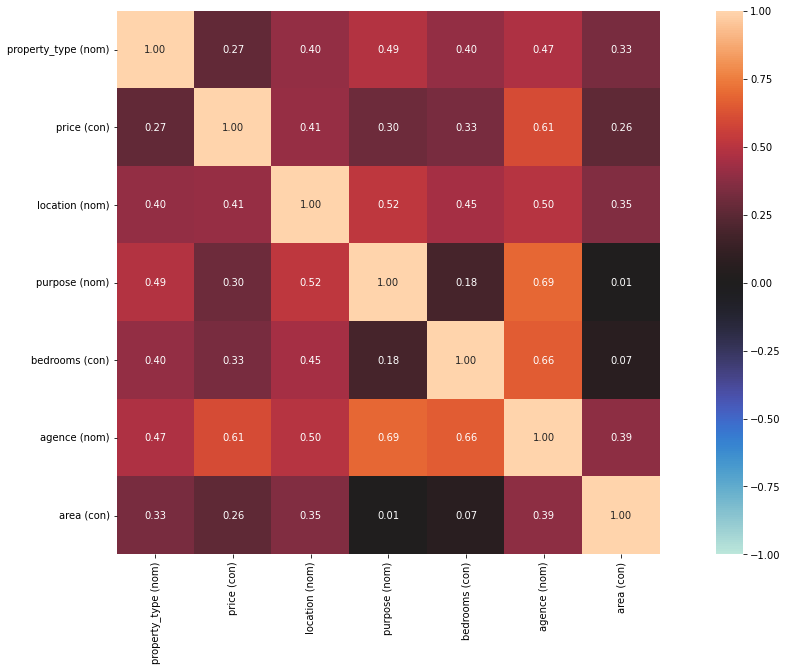

In [ ]:
df3 = df2.drop(['city', 'agent'],axis=1)
cor3 = nominal.associations(df3,figsize=(20,10),mark_columns=True, cmap=plt.cm.Reds);
 

## Model Visualization

In [ ]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(1)
ax = df['bedrooms'].value_counts().plot()
plt.title('number of Bedroom')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
sns.despine

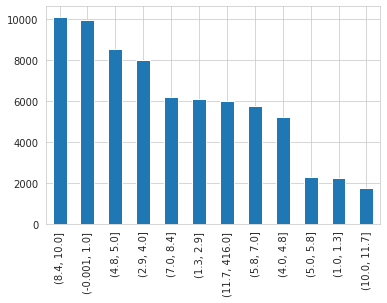

In [ ]:
ax = pd.qcut(df['area.1'], q=12).value_counts().plot(kind='bar')

In [ ]:
plt.figure(figsize=(10,10))
sns.jointplot(x=df.latitude.values, y=df.longitude.values, size = 5)
plt.title('pretty')
plt.ylabel('Longitube', fontsize = 12)
plt.xlabel('Latitude', fontsize = 12)
plt.show()
sns.color_palette("crest", as_cmap=True)
sns.despine

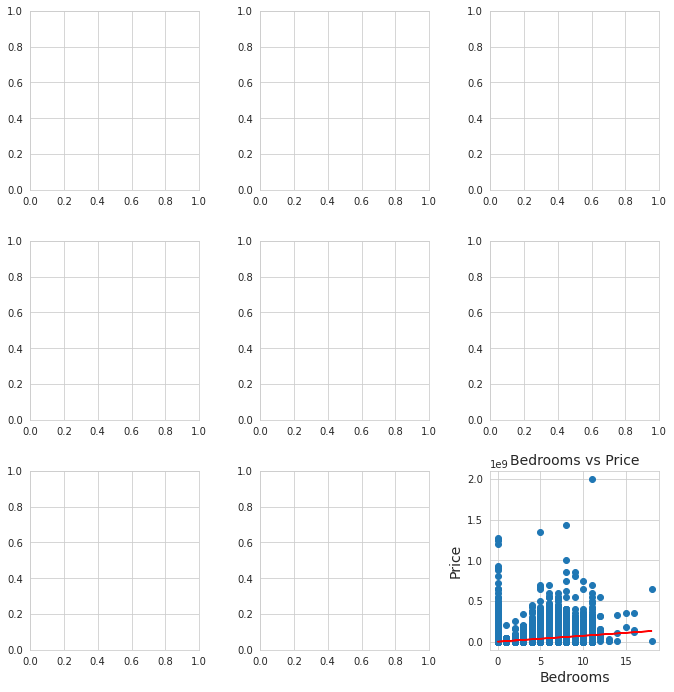

In [ ]:
fig, ax = plt.subplots(3,3, figsize =(10,10))
fig.tight_layout(pad=3.0)
sns.set_style('whitegrid')
ax[0,0] = plt.scatter(df3['bedrooms'], df3['price'])
ax[0,0] = plt.title('Bedrooms vs Price', fontsize=14)
ax[0,0] = plt.xlabel('Bedrooms', fontsize=14)
ax[0,0] = plt.ylabel('Price', fontsize=14)

m,b = np.polyfit(df3['bedrooms'], df3['price'], 1)

ax[0,0] = plt.plot(df3['bedrooms'], m* df3['bedrooms'] + b, color='red')
ax[0,0] = plt.show()

##Model Training

In [ ]:
df4 = pd.get_dummies(df3) 
df4

,price,bedrooms,area,property_type_Farm House,property_type_Flat,property_type_House,property_type_Lower Portion,property_type_Penthouse,property_type_Room,property_type_Upper Portion,location_12th Avenue,location_7th Avenue,location_9th Avenue,location_AWT Army Welfare Trust,location_Aabpara Coop Housing Society,location_Aashiana Road,location_Abbaspur,location_Abdalians Cooperative Housing Society,location_Abdul Sattar Edhi Road,location_Abdullah City,location_Abdullah Garden,location_Abdullah Haroon Road,location_Abdullah Town,location_Abid Town,location_Abul Hassan Isphani Road,location_Acro Green - Bankers Avenue,location_Adan Villas,location_Adiala Road,location_Affandi Colony,location_Afshan Colony,location_Agrics Town,location_Agro Farming Scheme,location_Ahbab Colony,location_Ahmad Avenue,location_Ahmad Housing Society,location_Ahmadabad,location_Ahmed Town,location_Air Avenue City,location_Air Force Housing Society,location_Airline Avenue,...,agence_Zaroon Estate Agency,agence_Zawiya Associates,agence_Zawiya Enterprises,agence_Zax Corporation,agence_Zayyan Marketing,agence_Zee Brothers (Pvt) Ltd.,agence_Zee Estate,agence_Zeeshan Associates,agence_Zeeshan Estate & Builders,agence_Zeeshan Estate Advisors,agence_Zeeshan Property Consultant,agence_Zeeshan Property Dealers & Builders,agence_Zeeshan Real Estate,agence_Zemax Property Consultant Pakistan,agence_Zenith Building Developer,agence_Zia Estate Advisor,agence_Zia Noor Real Estate,agence_Zia Real Estate,agence_Zian Estate Linkers,agence_Ziara Estate & Builders,agence_Zikria Associate,agence_Zisk Properties,agence_Ziyam Properties,agence_Zmaka Estate (Land Management Solutions),agence_Zohaib Associates,agence_Zohaib Enterprises,agence_Zone 2 Property Links,agence_Zorje Pvt Ltd,agence_Zubaida Real Estate,agence_Zubair Associates & Amira Construction,agence_Zubair Builders,agence_Zubair Estate,agence_Zubair Estate Advisor,agence_Zubair Estate Agency,agence_Zubair Properties,agence_Zulfiqar Enterprises,agence_Zuraaco Real Estate Services,agence_i Real Estate (Insaf Group),agence_iftikhar Chaudhary Real Estate Consultant,agence_maliktasaduq110@gmail. com
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,7000000,3,8.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7800000,2,6.2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,50000000,7,20.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,40000000,5,20.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,35000000,3,7.1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72151,25000000,4,8.4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
72152,30000,3,8.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
72153,10000,2,2.4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
reg = LinearRegression()

labels = df4['price']
train1 = df4.drop(['price'],axis=1)

x_train , x_test , y_train , y_test = train_test_split(train1 , labels , test_size = 0.20,random_state =  2)
reg.fit(x_train,y_train)
reg.score(x_test,y_test)


-6.282552029392148e+17

In [ ]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'ls')
clf.fit(x_train, y_train)
clf.score(x_test,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


0.7531675620952272

In [ ]:
!df -h


Filesystem      Size  Used Avail Use% Mounted on
overlay          79G   42G   37G  54% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.2G  817M  59% /sbin/docker-init
tmpfs           6.4G   36K  6.4G   1% /var/colab
/dev/sda1        86G   47G   40G  55% /opt/bin/.nvidia
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  9.0G  6.1G  60% /content/drive


In [ ]:
!cat /proc/cpuinfo


processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [ ]:
!cat /proc/meminfo



MemTotal:       13302920 kB
MemFree:         9384440 kB
MemAvailable:   11608956 kB
Buffers:          131672 kB
Cached:          2116908 kB
SwapCached:            0 kB
Active:          1833068 kB
Inactive:        1772252 kB
Active(anon):    1201280 kB
Inactive(anon):      468 kB
Active(file):     631788 kB
Inactive(file):  1771784 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               332 kB
Writeback:             0 kB
AnonPages:       1356764 kB
Mapped:           299400 kB
Shmem:              1200 kB
KReclaimable:     124836 kB
Slab:             176168 kB
SReclaimable:     124836 kB
SUnreclaim:        51332 kB
KernelStack:        6160 kB
PageTables:        19480 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6651460 kB
Committed_AS:    4044140 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       46260 kB
VmallocChunk:          0 kB
Percpu:          